Load dataset

In [1]:
!kaggle datasets download deepcontractor/supreme-court-judgment-prediction
!unzip supreme-court-judgment-prediction.zip

import pandas as pd

df = pd.read_csv('justice.csv')

print(df)


Dataset URL: https://www.kaggle.com/datasets/deepcontractor/supreme-court-judgment-prediction
License(s): CC0-1.0
 75% 1.00M/1.33M [00:00<00:00, 1.08MB/s]
100% 1.33M/1.33M [00:01<00:00, 1.36MB/s]
Archive:  supreme-court-judgment-prediction.zip
  inflating: justice.csv             
      Unnamed: 0     ID                                 name  \
0              0  50606                          Roe v. Wade   
1              1  50613                  Stanley v. Illinois   
2              2  50623              Giglio v. United States   
3              3  50632                         Reed v. Reed   
4              4  50643                 Miller v. California   
...          ...    ...                                  ...   
3298        3298  63324    United States v. Palomar-Santiago   
3299        3299  63323               Terry v. United States   
3300        3300  63331              United States v. Cooley   
3301        3301  63332                   Florida v. Georgia   
3302        33

Preprocess dataset

In [2]:
# Preprocess the data
# just keep facts and first_party_winner

#drop all rows with na
df = df.dropna()
df = df[['facts', 'first_party_winner']]
df['first_party_winner'] = df['first_party_winner'].astype(int)

#remname facts to text and first_party_winner to label
df = df.rename(columns={'first_party_winner': 'label', 'facts': 'text'})

# remove the p tag from the text
df['text'] = df['text'].str.replace('<p>', '')

print(df)

                                                   text  label
1     Joan Stanley had three children with Peter Sta...      1
2     John Giglio was convicted of passing forged mo...      1
3     The Idaho Probate Code specified that "males m...      1
4     Miller, after conducting a mass mailing campai...      1
5     Ernest E. Mandel was a Belgian professional jo...      1
...                                                 ...    ...
3297  For over a century after the Alaska Purchase i...      1
3298  Refugio Palomar-Santiago, a Mexican national, ...      1
3299  Tarahrick Terry pleaded guilty to one count of...      0
3300  Joshua James Cooley was parked in his pickup t...      1
3302  The Natural Gas Act (NGA), 15 U.S.C. §§ 717–71...      1

[3098 rows x 2 columns]



Use a light weight LLM model to predict which party will win based on some actual dataset records

imports for supervised fine tuning

In [3]:
!pip install datasets # install the datasets library
!pip install peft # install the peft library
!pip install evaluate # install the evaluate library

from datasets import load_dataset,  Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig

import evaluate
import torch
import numpy as np




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.5 MB/s eta 0:00:00


defining model to use or fine tune

In [4]:
model_checkpoint = "distilbert-base-uncased" # using this base model for doing binary classfication because it is the smallest parameter set, can run in this machine.

#we want to fine-tune this model to do case analysis on input text, for that we want to label map for First party wins and First party losses.

#define label maps
id2label = {0: "First Party Loses", 1: "First Party Wins"}
label2id = {"First Party Loses": 0, "First Party Wins": 1}

#generate classification model for model_checkpoint
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    id2label=id2label,
    label2id=label2id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dividing data to training and testing data from the given dataset

In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert the dataframes to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
validation_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.select_columns(['label', 'text'])
validation_dataset = validation_dataset.select_columns(['label', 'text'])

# Remove the index column if it exists
if '__index_level_0__' in train_dataset.features:
    train_dataset = train_dataset.remove_columns(['__index_level_0__'])
if '__index_level_0__' in validation_dataset.features:
    validation_dataset = validation_dataset.remove_columns(['__index_level_0__'])


#print(train_dataset)
#print(validation_dataset)

dataset = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset
})
dataset



DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 2478
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 620
    })
})

preprocess dataset wrt model

In [6]:
#create a tokenizer, for the particular model we are using.
# models don't understand text, need to convert them to numerical data before feeding to models
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space = True)

#create tokenize function,
#examples is rows in dataset the training dataset has 2 columns label and text, we want to grab text from it and convert into numerical values

def tokenize_function(examples):
  #extract text
   text = examples['text']

   #tokenize and truncate, required as examples for training need to be of the same length, truncate long or pad short, or do both.
   #here truncating form left, using numpy tensor, with max length 512
   tokenizer.truncate_side = "left"
   tokenized_inputs = tokenizer(text,
                                return_tensors = "np",
                                max_length=512,
                                truncation=True)

   return tokenized_inputs

   #add pad token if not exist, tokenizer doesn't have pad tokens so adding to sequence whenever PAD is there, it's ignored by LLM
   if tokenizer.pad_token is None:
      tokenizer.add_special_tokens({'pad_token': '[PAD]'})
      model.resize_token_embeddings(len(tokenizer))

#tokenize training and validation dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

# instead of doing padding for all rows, we can dynamically PAD the rows in the datasets using collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/2478 [00:00<?, ? examples/s]

Map:   0%|          | 0/620 [00:00<?, ? examples/s]

Evaluation metrics

In [7]:
#to import the performance of the model during training
#import accuracy evaluation metrics
from sklearn.metrics import classification_report
accuracy = evaluate.load("accuracy")

# packaging accuracy metrics as a function, one for first party losses and first party losses class, whichever is larger will become model prediction.
# define an evaluation function to pass into trainer later
# Evaluation metrics
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculate additional metrics
    report = classification_report(labels, predictions, output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']

    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)['accuracy'],
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

Applying untrained model to text

In [8]:
# define list of examples
text_list = test_df['text'][5:10].tolist()
actual_winner = test_df['label'][5:10].tolist()
print("Untrained model predictions:")
print("----------------------------")
for text in text_list:
    # tokenize text
    inputs = tokenizer.encode(text, return_tensors="pt")
    # compute logits
    logits = model(inputs).logits
    # convert logits to label
    predictions = torch.argmax(logits)

    print(id2label[predictions.tolist()]
          + " - Actual Result: " + id2label[actual_winner[text_list.index(text)]])

Untrained model predictions:
----------------------------
First Party Loses - Actual Result: First Party Wins
First Party Loses - Actual Result: First Party Loses
First Party Loses - Actual Result: First Party Wins
First Party Loses - Actual Result: First Party Wins
First Party Loses - Actual Result: First Party Wins


Train Model

In [9]:
peft_config = LoraConfig(task_type="SEQ_CLS", # sequence classification
                        r=4, #intrinsic rank of trainable weight matrix
                        lora_alpha=32, # learning rate
                        lora_dropout=0.01, # probability of drop out, randomly 0 internal parameters during training
                        target_modules = ['q_lin']
                         )

Use config setting to update model

In [10]:
model = get_peft_model(model, peft_config) # get actual model and update it using the configuration of lora that we provided in previous step
model.print_trainable_parameters() # to see how much percentage of total parameters we actually need to model, as seen in result only 0.93% of the model will be trained, huge cost savings.

trainable params: 610,562 || all params: 67,565,572 || trainable%: 0.9037


In [11]:
# hyperparameters
lr = 1e-3 # size of optimization step
batch_size = 4 # number of rows in dataset processed per optimization step
num_epochs = 10 #number of times model runs through training data

In [12]:
# define training arguments
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification", # defining where model to be saved
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy="epoch", # per epoch evaluate the model parameters
    save_strategy="epoch", # per epoch save the model parameters
    load_best_model_at_end=True, # at end return best version of the model
)

In [13]:
# Create a Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

TrainOutput(global_step=6200, training_loss=0.6082773627004315, metrics={'train_runtime': 731.9153, 'train_samples_per_second': 33.856, 'train_steps_per_second': 8.471, 'total_flos': 2210377083233040.0, 'train_loss': 0.6082773627004315, 'epoch': 10.0})

In [14]:
# define list of examples
text_list = test_df['text'][5:10].tolist()
actual_winner = test_df['label'][5:10].tolist()
print("Trained model predictions:")
print("----------------------------")
for text in text_list:
    # tokenize text
    inputs = tokenizer.encode(text, return_tensors="pt").to("cuda")
    # compute logits
    logits = model(inputs).logits
    # convert logits to label
    predictions = torch.argmax(logits)

    print(id2label[predictions.tolist()]
          + " - Actual Result: " + id2label[actual_winner[text_list.index(text)]])

Trained model predictions:
----------------------------
First Party Wins - Actual Result: First Party Wins
First Party Wins - Actual Result: First Party Loses
First Party Wins - Actual Result: First Party Wins
First Party Wins - Actual Result: First Party Wins
First Party Wins - Actual Result: First Party Wins


Using Explainable AI with LoRA

In [43]:
!pip install shap transformers-interpret


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.4 MB/s eta 0:00:00


In [81]:
import shap
from transformers_interpret import SequenceClassificationExplainer

def model_wrapper(input_ids):
    # Convert the list of strings to numerical token IDs using the tokenizer
    # input_ids = tokenizer.convert_tokens_to_ids(input_ids) # Removed this line
    # Modified to handle multiple sequences for SHAP explainer
    input_ids = [tokenizer.encode(text) for text in input_ids]  # Encode each text in the input_ids list
    max_len = max(len(ids) for ids in input_ids)  # Determine the maximum length of the tokenized inputs
    # Pad each sequence to the maximum length to ensure uniform input dimensions
    padded_input_ids = [ids + [tokenizer.pad_token_id] * (max_len - len(ids)) for ids in input_ids]
    input_ids = torch.tensor(padded_input_ids, dtype=torch.long).to("cuda")  # Convert to torch tensor and move to GPU
    logits = model(input_ids).logits  # Get the logits from the model
    return logits.cpu().detach().numpy()  # Return logits as a NumPy array

def text_masker(text, mask):
    tokens = tokenizer.tokenize(text)  # Tokenize the input text
    # Create masked tokens by replacing tokens with [MASK] where mask is False
    masked_tokens = [tokens[i] if mask[i] else "[MASK]" for i in range(len(tokens))]
    masked_text = tokenizer.convert_tokens_to_string(masked_tokens)  # Convert tokens back to string
    return masked_text

def get_attention_weights(text):
    inputs = tokenizer(text, return_tensors="pt").to("cuda")  # Tokenize the input text and move to GPU
    outputs = model(**inputs, output_attentions=True)  # Get the model outputs including attention weights
    return outputs.attentions[-1]  # Return the last layer's attention weights

def explain_prediction_shap(text):
    # Get the token IDs directly from the tokenizer
    # input_ids = tokenizer.encode(text)  # Removed this line
    # input_ids = np.array(input_ids).astype(int)  # Removed this line

    # Create a text masker to perturb the input text.
    masker = shap.maskers.Text(tokenizer, mask_token="[MASK]")
    explainer = shap.Explainer(model_wrapper, masker=masker, output_names=list(id2label.values()))  # Initialize SHAP explainer

    # Pass the text as a single-element list to the explainer
    shap_values = explainer([text])
    shap.plots.text(shap_values[0])  # Visualize SHAP values for the input text

    # Get attention weights and visualize the attention map
    attention_weights = get_attention_weights(text)
    tokens = tokenizer.tokenize(text)
    plt.imshow(attention_weights[0, 0, :, :].cpu().detach().numpy(), cmap='viridis')  # Display attention weights as heatmap
    plt.xticks(range(len(tokens)), tokens, rotation=90)  # Set x-ticks to token positions
    plt.yticks(range(len(tokens)), tokens)  # Set y-ticks to token positions
    plt.colorbar()  # Add color bar to the heatmap
    plt.show()  # Show the plot


Trained model predictions:
----------------------------
First Party Wins - Actual Result: First Party Wins


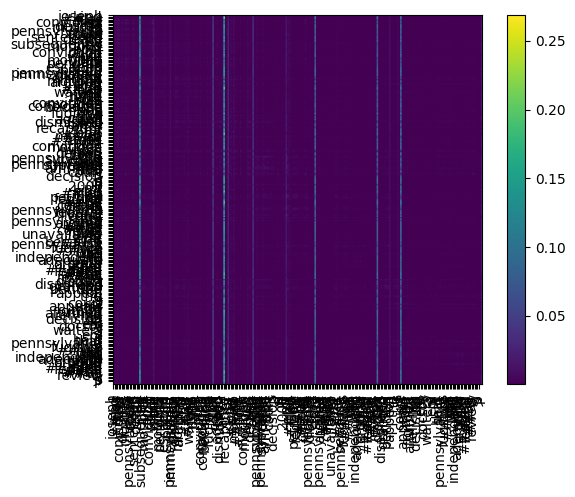

First Party Wins - Actual Result: First Party Loses


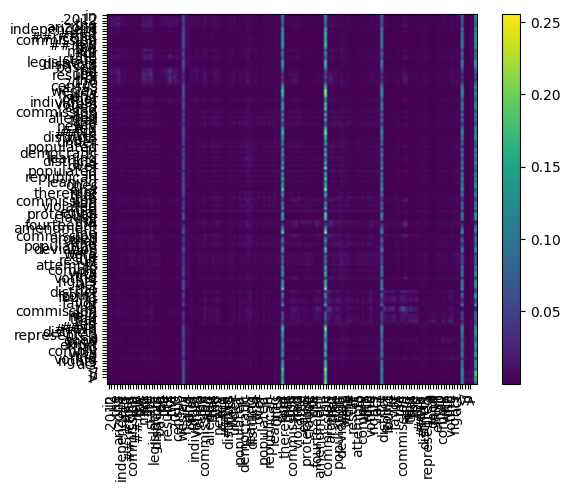

First Party Wins - Actual Result: First Party Wins


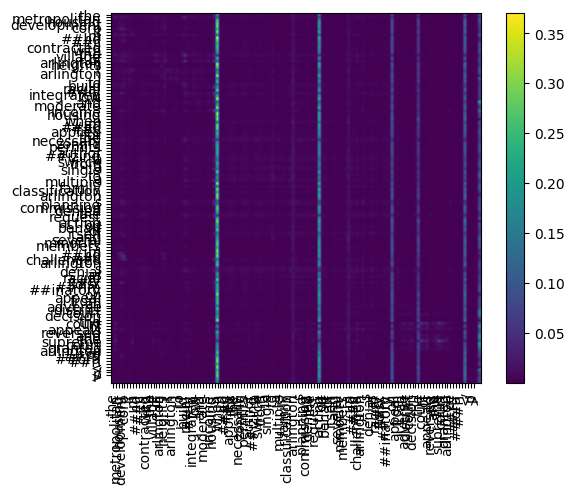

First Party Wins - Actual Result: First Party Wins


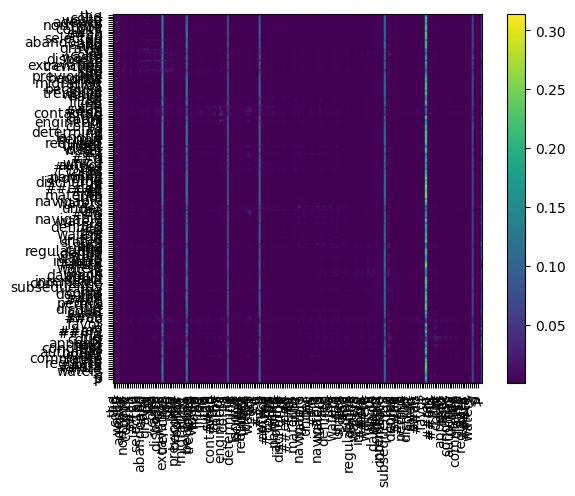

First Party Wins - Actual Result: First Party Wins


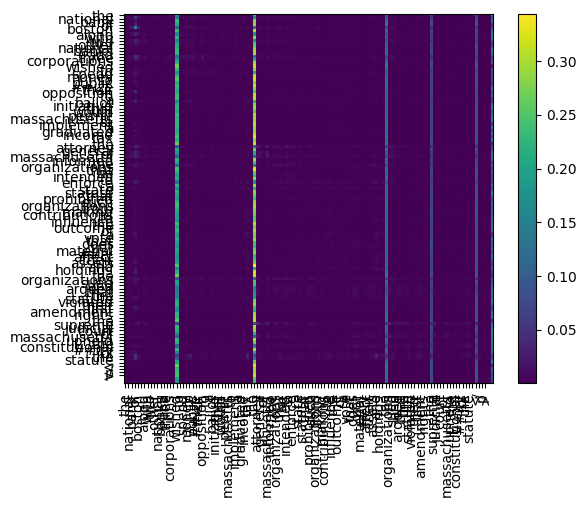

In [78]:
text_list = test_df['text'][5:10].tolist()
actual_winner = test_df['label'][5:10].tolist()

print("Trained model predictions:")
print("----------------------------")
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt").to("cuda")
    logits = model(inputs).logits
    predictions = torch.argmax(logits, dim=1)
    print(id2label[predictions.item()] + " - Actual Result: " + id2label[actual_winner[text_list.index(text)]])

    # Explain the prediction using SHAP and attention map
    explain_prediction_shap(text)
